In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 1
Epoch 1/30: Train Loss: 0.2612, Train Accuracy: 0.8868, Val Loss: 0.1486, Val Accuracy: 0.9562
Epoch 2/30: Train Loss: 0.0928, Train Accuracy: 0.9640, Val Loss: 0.0568, Val Accuracy: 0.9875
Epoch 3/30: Train Loss: 0.0298, Train Accuracy: 0.9906, Val Loss: 0.0689, Val Accuracy: 0.9844
Epoch 4/30: Train Loss: 0.0342, Train Accuracy: 0.9918, Val Loss: 0.0423, Val Accuracy: 0.9875
Epoch 5/30: Train Loss: 0.0436, Train Accuracy: 0.9855, Val Loss: 0.0362, Val Accuracy: 0.9859
Epoch 6/30: Train Loss: 0.0296, Train Accuracy: 0.9902, Val Loss: 0.0947, Val Accuracy: 0.9718
Epoch 7/30: Train Loss: 0.0516, Train Accuracy: 0.9835, Val Loss: 0.0310, Val Accuracy: 0.9922
Epoch 8/30: Train Loss: 0.0514, Train Accuracy: 0.9835, Val Loss: 0.0609, Val Accuracy: 0.9797
Epoch 9/30: Train Loss: 0.0218, Train Accuracy: 0.9918, Val Loss: 0.0332, Val Accuracy: 0.9937
Epoch 10/30: Train Loss: 0.0050, Train Accuracy: 0.9984, Val Loss: 0.0347, Val Accuracy: 0.9937
Epoch 11/30: Train Loss: 0.0058, Train Ac

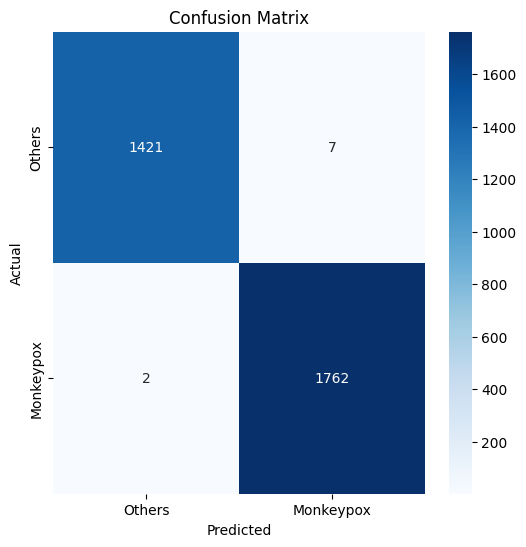

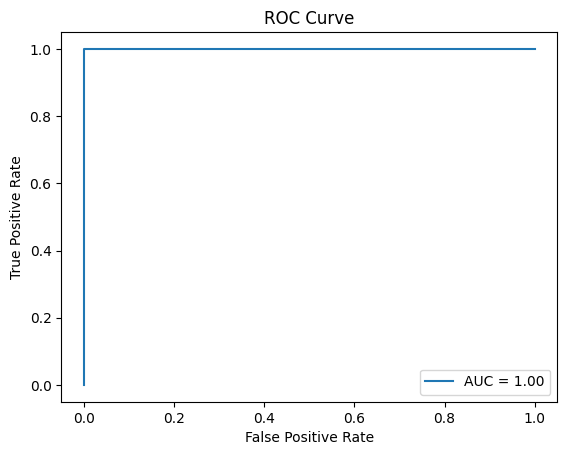

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
from transformers import SwinForImageClassification
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Paths and parameters
folder_path = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
subfolders = ['Monkeypox_augmented', 'Others_augmented']
image_size = (224, 224)
batch_size = 16
epochs = 30
learning_rate = 0.0001

# Image transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
data, labels = [], []
label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}

for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            data.append(img)
            labels.append(label_map[subfolder])

data = np.array(data).astype("float32")
labels = np.array(labels)

data = torch.tensor(data).permute(0, 3, 1, 2) / 255.0  # Normalize
labels = torch.tensor(labels)

dataset = TensorDataset(data, labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224", 
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

class SwinClassifier(nn.Module):
    def __init__(self, swin_model):
        super(SwinClassifier, self).__init__()
        self.swin_model = swin_model
    
    def forward(self, x):
        return self.swin_model(pixel_values=x).logits

criterion = nn.CrossEntropyLoss()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []
all_preds, all_targets, all_probs = [], [], []
precision_scores, recall_scores, f1_scores = [], [], []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = accuracy_score(train_targets, train_preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss, val_preds, val_targets, val_probs = 0.0, [], [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                
        val_loss /= len(val_loader.dataset)
        val_accuracy = accuracy_score(val_targets, val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies, val_preds, val_targets, val_probs

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Others', 'Monkeypox'], yticklabels=['Others', 'Monkeypox'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(train_losses, 'r-', label='Train Loss')
    ax1.plot(val_losses, 'b-', label='Val Loss')
    ax2.plot(train_accuracies, 'g-', label='Train Acc')
    ax2.plot(val_accuracies, 'y-', label='Val Acc')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax1.legend()
    ax2.legend()
    plt.title('Loss and Accuracy Curves')
    plt.show()

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f"\nFold {fold + 1}")
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    model = SwinClassifier(base_model).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, train_accuracies, val_accuracies, val_preds, val_targets, val_probs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)
    
    all_preds.extend(val_preds)
    all_targets.extend(val_targets)
    all_probs.extend(val_probs)
    
    fold_results.append(np.mean(val_accuracies))  # Store fold validation accuracy
    precision_scores.append(precision_score(val_targets, val_preds, average='weighted'))
    recall_scores.append(recall_score(val_targets, val_preds, average='weighted'))
    f1_scores.append(f1_score(val_targets, val_preds, average='weighted'))

# Compute and print final metrics
average_accuracy = np.mean(fold_results)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

print(f"\nFinal Metrics over 5 folds:")
print(f"Average Validation Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-score: {average_f1:.4f}")

# Plot results
plot_confusion_matrix(all_targets, all_preds)
plot_roc_curve(all_targets, np.array(all_probs))


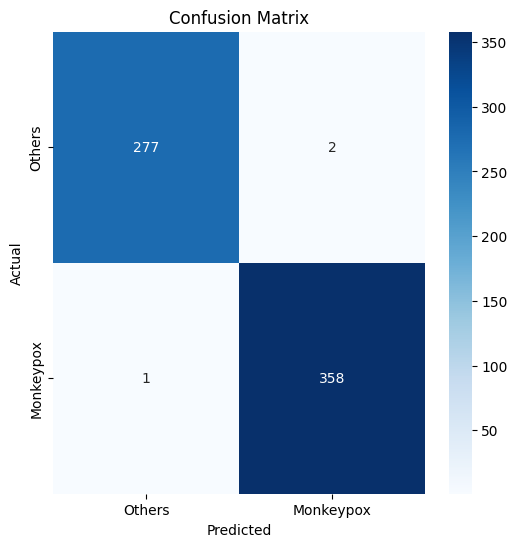

In [4]:


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Others', 'Monkeypox'], yticklabels=['Others', 'Monkeypox'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(val_targets, val_preds)


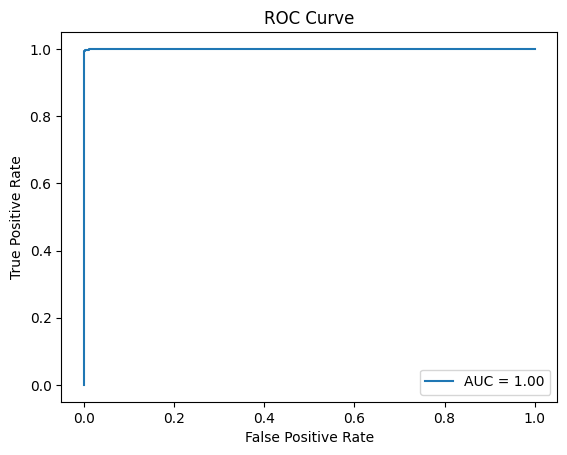

In [5]:
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
plot_roc_curve(val_targets, np.array(val_probs))

In [11]:
import torch.onnx

# Save the trained model as ONNX
model_path = "swin_transformer_model.onnx"
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example input shape
torch.onnx.export(model, dummy_input, model_path, opset_version=11)

print(f"Model saved in ONNX format at {model_path}")


/usr/local/lib/python3.10/dist-packages/transformers/models/swin/modeling_swin.py:349: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if width % self.patch_size[1] != 0:
/usr/local/lib/python3.10/dist-packages/transformers/models/swin/modeling_swin.py:352: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height % self.patch_size[0] != 0:
/usr/local/lib/python3.10/dist-packages/transformers/models/swin/modeling_swin.py:652: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Pytho

Model saved in ONNX format at swin_transformer_model.onnx
